In [42]:
library(broom)
library(latex2exp)
library(tidyverse)
library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(GGally)
library(AER)

# Preliminary Results
## Predicting Used Vehicle Listing Price 
#### By: Matthew Gillies, Helin Wang,  Qingfeng Shen, Hanyu Dai

In [43]:
## Loading in dataset:
setwd("/Users/matthewgillies")
car_data <- read_csv("STAT301Proj/autos.csv") #%>% select(-dateCrawled, -dateCreated, -lastSeen)
head(car_data)

Rows: 367904 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): name, seller, offerType, abtest, vehicleType, gearbox, model, fue...
dbl   (6): price, yearOfRegistration, powerPS, kilometer, monthOfRegistratio...
dttm  (3): dateCrawled, dateCreated, lastSeen

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in FUN(X[[i]], ...):
“input string 2 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 2 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 2 is invalid in this locale”
ERROR while rich displaying an object: Error in gsub(chr, html_specials[[chr]], text, fixed = TRUE): input string 2 is invalid in this locale

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", 

dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
<dttm>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<chr>,<dttm>
2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NA,1993,manuell,0,golf,150000,0,benzin,volkswagen,NA,2016-03-24,0,70435,2016-04-07 03:16:57
2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NA,125000,5,diesel,audi,ja,2016-03-24,0,66954,2016-04-07 01:46:50
2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NA,2016-03-14,0,90480,2016-04-05 12:47:46
2016-03-17 16:54:04,GOLF_4_1_4__3TRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17
2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21
2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Export,privat,Angebot,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04,0,33775,2016-04-06 19:17:07


## Data Cleaning and Preparation

In [44]:
## Removing NA's from dataset
car_data_clean <- car_data %>% na.omit()
sum(is.na(car_data_clean))

[1] 0

In [45]:
## Creating new column to represent age of the vehicle, since all ads are from 2016
car_data_clean$Year <- as.numeric(format(car_data_clean$dateCreated, "%Y"))
car_data_clean1 <- car_data_clean %>% mutate(Age = Year - yearOfRegistration) %>% select(-Year, -yearOfRegistration)
head(car_data_clean1)

Warning message in FUN(X[[i]], ...):
“input string 2 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 2 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 2 is invalid in this locale”
ERROR while rich displaying an object: Error in gsub(chr, html_specials[[chr]], text, fixed = TRUE): input string 2 is invalid in this locale

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mi

dateCrawled,name,seller,offerType,price,abtest,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,Age
<dttm>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<chr>,<dttm>,<dbl>
2016-03-17 16:54:04,GOLF_4_1_4__3TRER,privat,Angebot,1500,test,kleinwagen,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17,15
2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21,8
2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Export,privat,Angebot,650,test,limousine,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04,0,33775,2016-04-06 19:17:07,21
2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,privat,Angebot,2200,test,cabrio,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,2016-04-01,0,67112,2016-04-05 18:18:39,12
2016-03-21 18:54:38,VW_Derby_Bj_80__Scheunenfund,privat,Angebot,0,test,limousine,manuell,50,andere,40000,7,benzin,volkswagen,nein,2016-03-21,0,19348,2016-03-25 16:47:58,36
2016-03-26 19:54:18,Mazda_3_1.6_Sport,privat,Angebot,2000,control,limousine,manuell,105,3_reihe,150000,12,benzin,mazda,nein,2016-03-26,0,96224,2016-04-06 10:45:34,12


In [46]:
car_data_clean1 %>% count(nrOfPictures)
car_data_clean1 %>% count(abtest)

nrOfPictures,n
<dbl>,<int>
0,258399


abtest,n
<chr>,<int>
control,124198
test,134201


In [47]:
## Selecting desired columns:
## We will remove dateCrawled, name, postalCode, dateCreated and lastSeen as these columns are very specific and 
## will not be valuable to our prediction model. We will also remove nrOfPictures as the entire column is zeroes, 
## and abtest as this column is irrelevant in predicting the price. 

car_data_desired <- car_data_clean1 %>% select(-dateCrawled, -name, -postalCode, -dateCreated, -lastSeen, 
                                                 -nrOfPictures, -abtest)
head(car_data_desired)

seller,offerType,price,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,Age
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
privat,Angebot,1500,kleinwagen,manuell,75,golf,150000,6,benzin,volkswagen,nein,15
privat,Angebot,3600,kleinwagen,manuell,69,fabia,90000,7,diesel,skoda,nein,8
privat,Angebot,650,limousine,manuell,102,3er,150000,10,benzin,bmw,ja,21
privat,Angebot,2200,cabrio,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,12
privat,Angebot,0,limousine,manuell,50,andere,40000,7,benzin,volkswagen,nein,36
privat,Angebot,2000,limousine,manuell,105,3_reihe,150000,12,benzin,mazda,nein,12


In [48]:
nrow(car_data_clean1 %>% count(model))

[1] 250

In [49]:
## We will also remove the model column, as the extremely large amount of discrete values in this column will make it very hard
## to interpret the model when one-hot encoding is applied. This column is also represented in a more compact form through the 
## brand column. 

car_data_desired <- car_data_desired %>% select(-model)

In [50]:
car_data_clean1 %>% count(seller)
car_data_clean1 %>% count(offerType)

seller,n
<chr>,<int>
gewerblich,2
privat,258397


offerType,n
<chr>,<int>
Angebot,258395
Gesuch,4


In [51]:
## We will also filter the seller and offerType columns to contain only values that include private (privat) sellers and 
## offers (Angebot) to ensure our data is consistent throughout. These columns can be removed following the filtering as they 
## will have no effect on the prediction
car_data1 <- car_data_desired %>% filter(seller == "privat", offerType == "Angebot")
car_data_ready <- car_data1 %>% select(-seller, -offerType)
head(car_data_ready)

price,vehicleType,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,Age
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1500,kleinwagen,manuell,75,150000,6,benzin,volkswagen,nein,15
3600,kleinwagen,manuell,69,90000,7,diesel,skoda,nein,8
650,limousine,manuell,102,150000,10,benzin,bmw,ja,21
2200,cabrio,manuell,109,150000,8,benzin,peugeot,nein,12
0,limousine,manuell,50,40000,7,benzin,volkswagen,nein,36
2000,limousine,manuell,105,150000,12,benzin,mazda,nein,12


In [52]:
## Scaling kilometer column (divide by 10000)
car_data_ready <- car_data_ready %>% mutate(kilometer = kilometer / 10000)

In [53]:
# Inspecting summary of the data frame
summary(car_data_ready)

     price          vehicleType          gearbox             powerPS       
 Min.   :       0   Length:258393      Length:258393      Min.   :    0.0  
 1st Qu.:    1500   Class :character   Class :character   1st Qu.:   78.0  
 Median :    3850   Mode  :character   Mode  :character   Median :  116.0  
 Mean   :    8221                                         Mean   :  126.3  
 3rd Qu.:    8600                                         3rd Qu.:  150.0  
 Max.   :99999999                                         Max.   :20000.0  
   kilometer     monthOfRegistration   fuelType            brand          
 Min.   : 0.50   Min.   : 0.000      Length:258393      Length:258393     
 1st Qu.:10.00   1st Qu.: 3.000      Class :character   Class :character  
 Median :15.00   Median : 6.000      Mode  :character   Mode  :character  
 Mean   :12.41   Mean   : 6.182                                           
 3rd Qu.:15.00   3rd Qu.: 9.000                                           
 Max.   :15.00   M

In [54]:
## Selecting only numeric columns:
car_data_num <- car_data_ready %>% select(price, Age, powerPS, kilometer, monthOfRegistration)

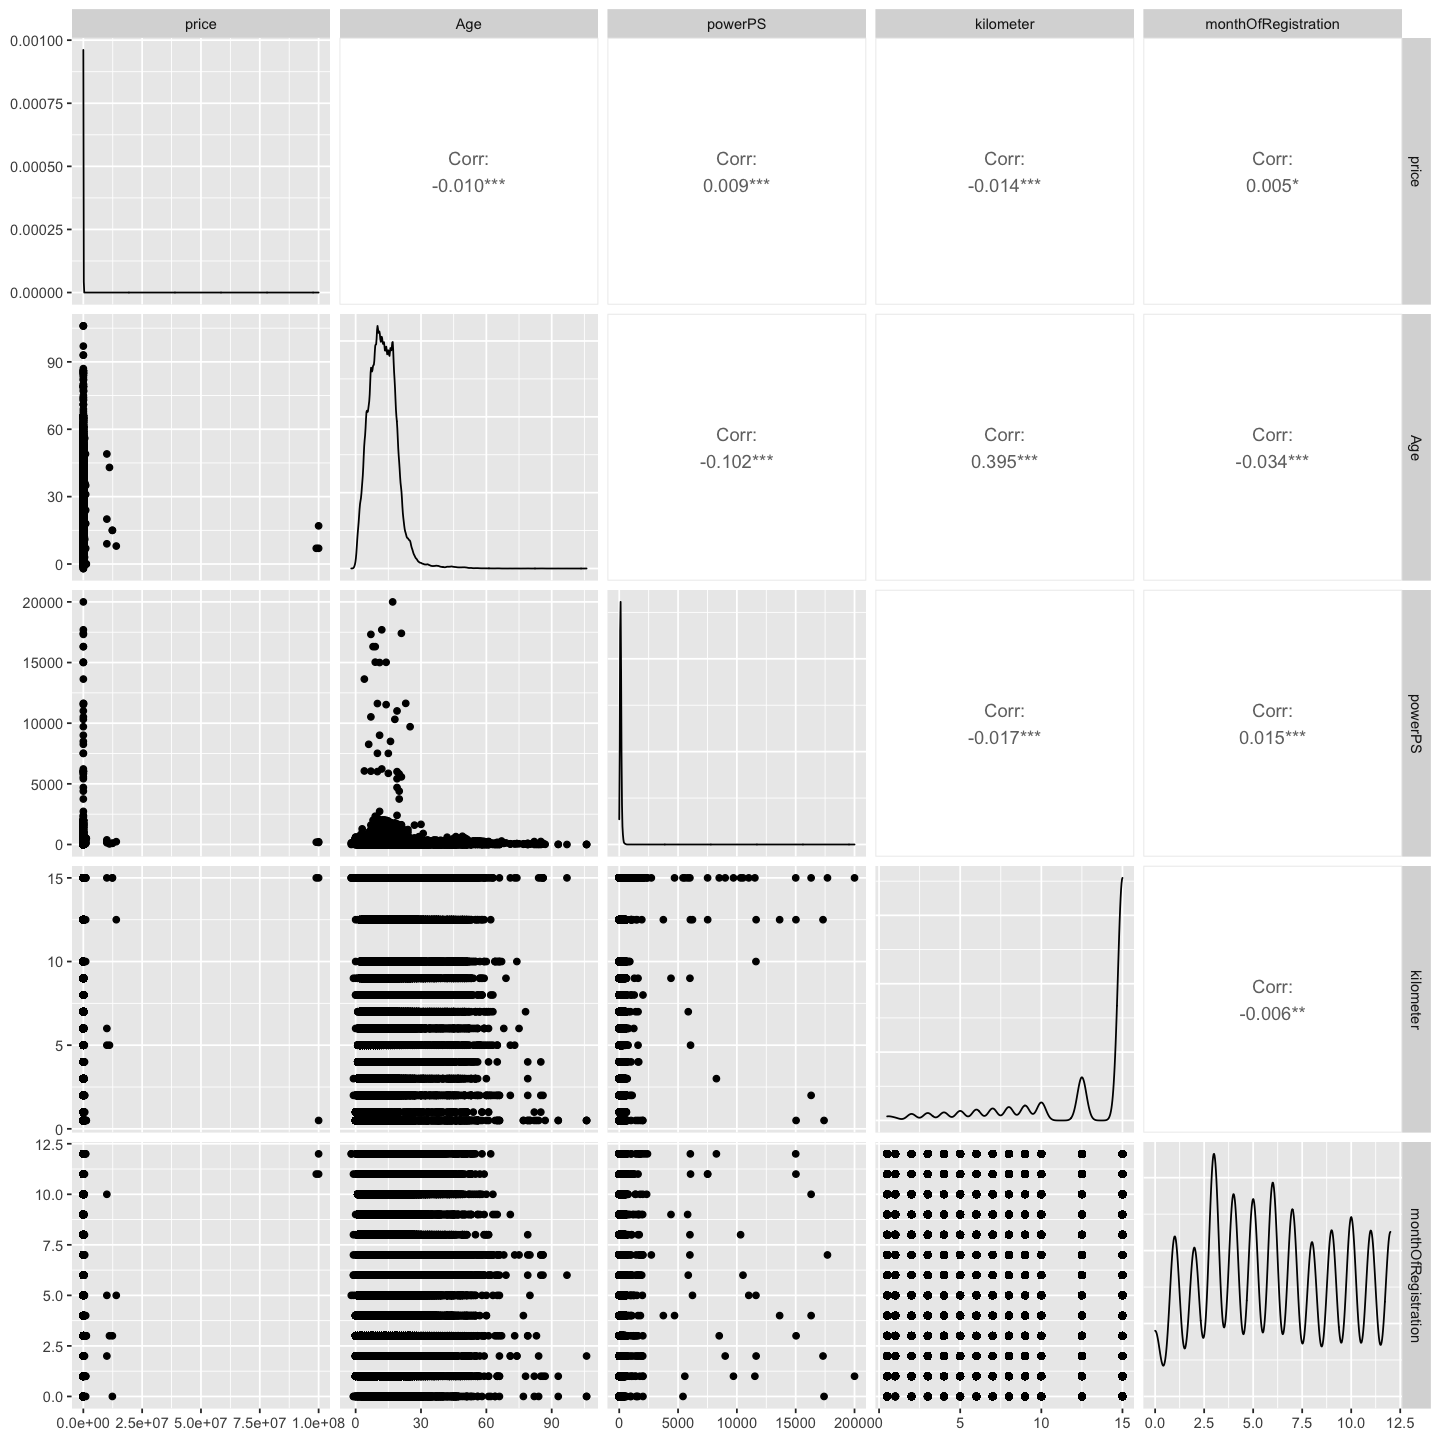

In [55]:
## Examining correlations visually:
ggpairs(car_data_num)

The correlations appear to have odd shapes, it seems that much of the data was rounded or split into "categories" rather than keeping the exact value. 

In [56]:
# Examining correlation values as a dataframe: 
corr_matrix_cars <- car_data_num %>%
cor() %>%
as.data.frame() %>%
rownames_to_column("variable1") %>%
pivot_longer(-variable1, names_to = "variable2", values_to = "correlation")
corr_matrix_cars

variable1,variable2,correlation
<chr>,<chr>,<dbl>
price,price,1.000000000
price,Age,-0.010405542
price,powerPS,0.008592722
price,kilometer,-0.013902377
price,monthOfRegistration,0.004792102
Age,price,-0.010405542
Age,Age,1.000000000
Age,powerPS,-0.101883797
Age,kilometer,0.394782517


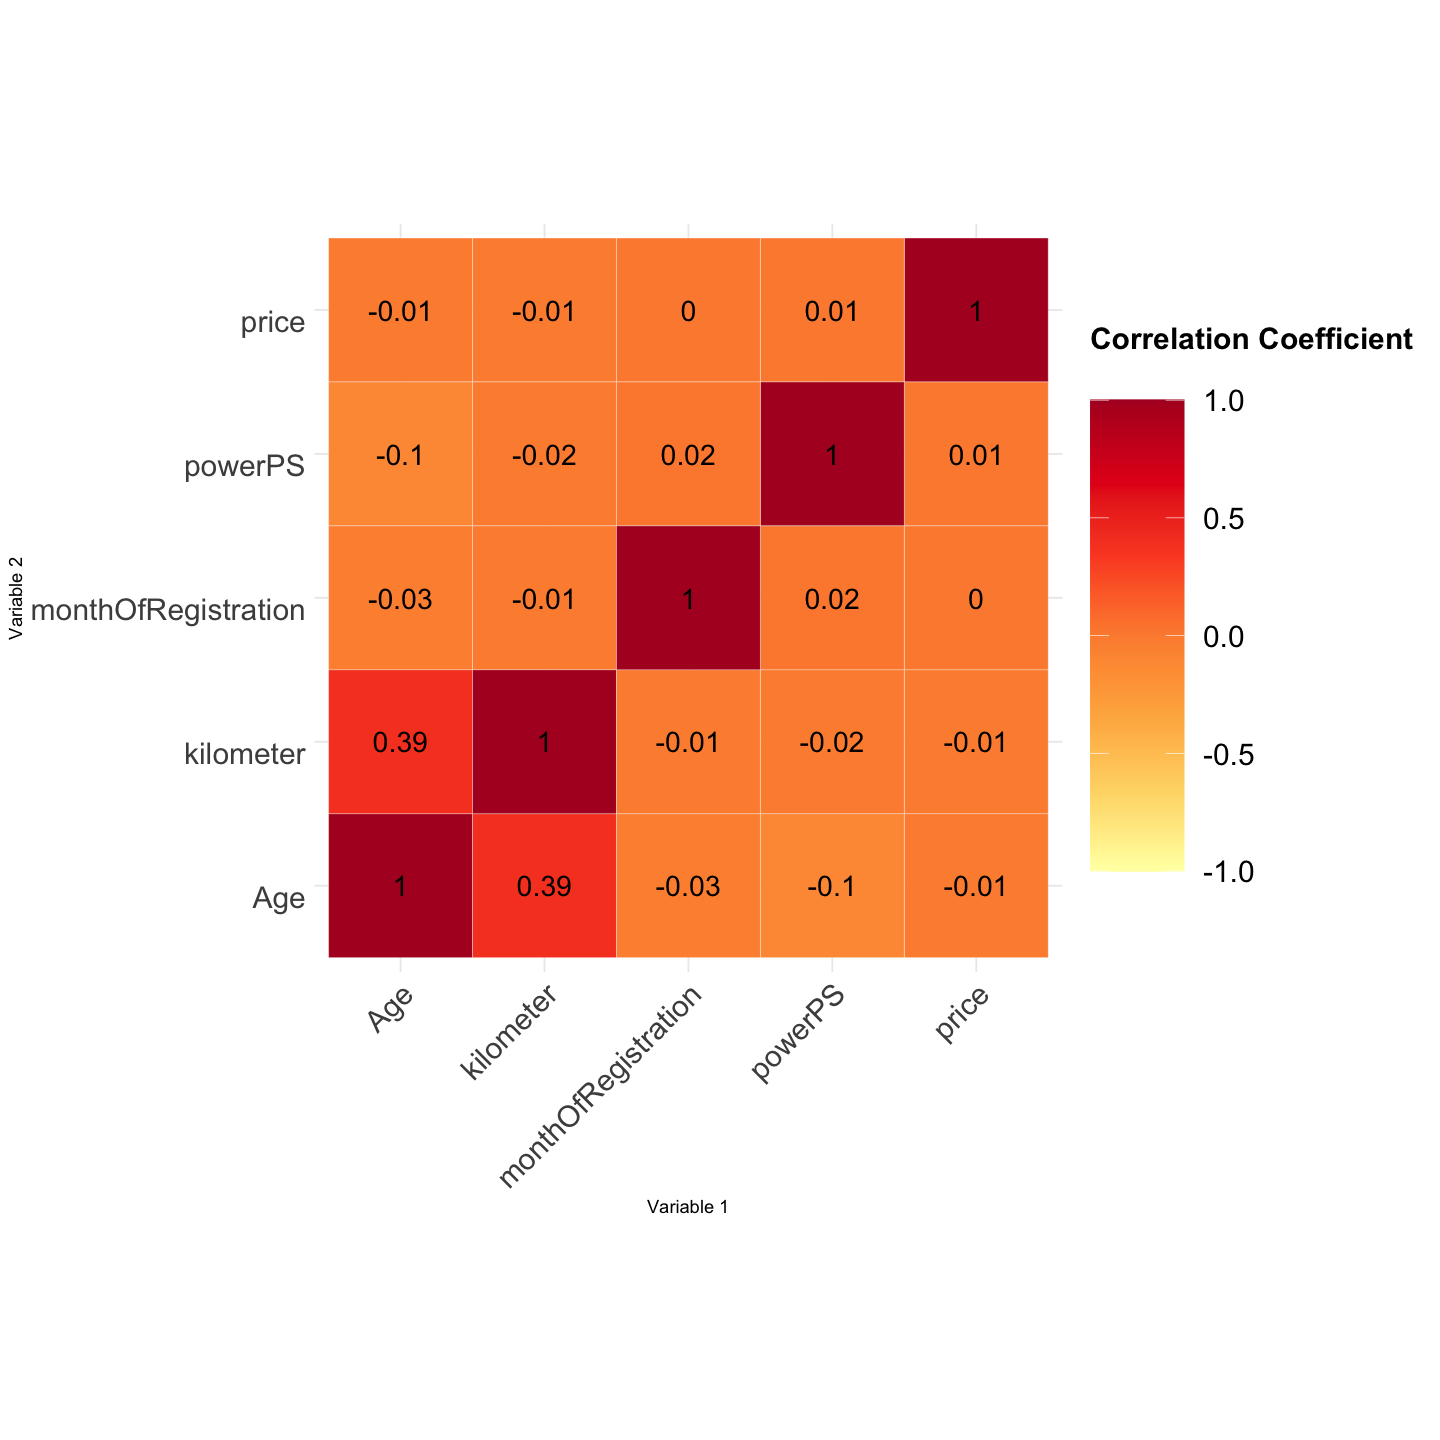

In [57]:
## Examining correlation values through heatmap
options(repr.plot.width = 12, repr.plot.height = 12)
plot_corr_matrix_car <- corr_matrix_cars %>%
  ggplot(aes(variable1, variable2)) +
  geom_tile(aes(fill = correlation), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "Variable 1", y = "Variable 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(variable1, variable2, label = round(correlation, 2)), color = "black", size = 6)
plot_corr_matrix_car

From the correlation heatmap we see that the numeric variables are all quite minimally correlated. The only correlation greater than 0.1 is the correlation between year of registration and kilometers, which is intuitive as the older a vehicle is, the more it has likely been driven. Therefore it is likely that either the large correlations lie within the categorical variables, or there are generally low correlations between all explanatory variables. 

In [58]:
## Splitting into training and testing data with 70/30 split
set.seed(124)
car_data_ready$Index <- 1:nrow(car_data_ready)
training_car <- sample_n(car_data_ready, size = nrow(car_data_ready) * 0.7, replace = FALSE)
testing_car <- anti_join(car_data_ready, training_car, by = "Index")
head(training_car)
head(testing_car)


price,vehicleType,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,Age,Index
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
7900,suv,automatik,166,15,8,lpg,suzuki,nein,7,26791
4400,kleinwagen,manuell,115,15,2,benzin,mini,ja,10,91547
9500,limousine,manuell,150,9,10,benzin,bmw,nein,12,19160
3300,kombi,manuell,90,15,10,diesel,volkswagen,nein,16,97709
1980,kleinwagen,manuell,50,15,11,benzin,volkswagen,nein,14,83873
2000,limousine,manuell,82,15,3,benzin,mitsubishi,nein,14,187227


price,vehicleType,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,Age,Index
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
3600,kleinwagen,manuell,69,9,7,diesel,skoda,nein,8,2
0,limousine,manuell,50,4,7,benzin,volkswagen,nein,36,5
7550,bus,manuell,136,15,6,diesel,ford,nein,9,10
1850,bus,manuell,102,15,1,benzin,mercedes_benz,nein,12,11
6900,limousine,manuell,99,6,11,benzin,honda,nein,8,17
690,kleinwagen,manuell,60,15,3,benzin,fiat,nein,13,19


In [59]:
## Performing forward selection to determine the input variables that provide the best model. 
forward_sel <- regsubsets(x = price ~., nvmax = 58, data = training_car, method = "forward")
forward_summary <- summary(forward_sel)

In [60]:
## Examining the statistics of each model to choose the best model, as we plan to predict we will choose the model with the
## lowest Cp
forward_summary_df <- tibble(
    n_input_variables = 1:58,
    RSQ = forward_summary$rsq,
    RSS = forward_summary$rss,
    ADJ.R2 = forward_summary$adjr2,
    Cp = forward_summary$cp,
    BIC = forward_summary$bic,
)
forward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0001957503,2.026454e+16,0.0001902227,44.3256001,-11.198682
2,0.0003496864,2.026142e+16,0.0003386327,18.4707513,-26.943905
3,0.0004821175,2.025873e+16,0.0004655391,-3.4927547,-38.801785
4,0.0005547663,2.025726e+16,0.0005326633,-14.6386157,-39.843397
5,0.0005880434,2.025658e+16,0.0005604153,-18.6601219,-33.760263
6,0.0006186090,2.025596e+16,0.0005854561,-22.1909863,-27.186588
7,0.0006404907,2.025552e+16,0.0006018130,-24.1505059,-19.041382
8,0.0006692945,2.025494e+16,0.0006250925,-27.3625740,-12.149121
9,0.0006844849,2.025463e+16,0.0006347581,-28.1112859,-2.792982


It appears that the model with 10 input variables will produce the most accurate predictions. We will now obtain the variables that are present in this model using forward_summary. 

Variables to use: vehicleTypecoupe, vehicleTypekombi, gearboxmanuell, kilometer, monthOfRegistration, fuelTypediesel, brandaudi, brandmercedes_benz, brandporsche, Age

Please note I refrain from printing forward summary due to the extremely large output it produces.